# Moral scoring of text using word embeddings

In [1]:
from utils import make_concepts_from_lexicon
from gensim.models import KeyedVectors
from utils import make_one_concept
emb_path = "data/embeddings/glove.twitter.27B.200d.word2vec"
embedding = KeyedVectors.load_word2vec_format(emb_path, binary=False)

## Create concepts

- Each concept is represented by a list of words
- Each word has a vector representation in the embedding
- The embedding of the concept = average embedding of the words

In [2]:
# Hand-craft a lexicon
lexicon = {
    "care_virtue": ["kindness", "compassion", "nurture", "empathy"],
    "care_vice": ["suffer", "cruel", "hurt", "harm"],
    "fairness_virtue": ["fairness", "equality", "patriot", "fidelity"],
    "fairness_vice": ["cheat", "fraud", "unfair", "injustice"],
    "loyalty_virtue": ["loyal", "team", "patriot", "fidelity"],
    "loyalty_vice": ["betray", "treason", "disloyal", "traitor"],
    "authority_virtue": ["authority", "obey", "respect", "tradition"],
    "authority_vice": ["subversion", "disobey", "disrespect", "chaos"],
    "sanctity_virtue": ["purity", "sanctity", "sacred", "wholesome"],
    "sanctity_vice": ["impurity", "depravity", "degradation", "unnatural"]
}

# Create concept vectors
concepts = make_concepts_from_lexicon(lexicon=lexicon, model=embedding,
                                      verbose=False, normalize=True)

In [3]:
# import json
# with open("data/lexicons/mfd12_lex.json", "r") as f:
#     lexicon = json.load(f)
# with open("data/concepts/mfd12_glove_twitter_200d.json") as f:
#     concepts = json.load(f)

## Score a document

- Tokenize a document
- Calculate cosine similarity between each token and the concept vector
- Average the cosine similarities

In [4]:
from gensim.utils import simple_preprocess
def score_tokens(document, concepts, embedding):
    def score_one_concept(tokens_vectors, concept):
        sims = embedding.cosine_similarities(concept, tokens_vectors)
        return np.mean(sims)
    
    if type(document) == str:
        tokens = simple_preprocess(document)
    else:
        tokens = document
    tokens_vectors = []
    for w in tokens:
        if w not in embedding: continue
        w = embedding[w]
        tokens_vectors.append(w)

    if len(tokens_vectors) <= 0:
        tokens_vectors.append(np.zeros(embedding["x"].shape))
    
    scores = {}
    for concept, concept_vector in concepts.items():
        scores[concept] = score_one_concept(concept=concept_vector, 
                                            tokens_vectors=tokens_vectors)
    scores = pd.Series(scores).sort_values(ascending=False)
    return scores

In [5]:
import pandas as pd
import ast
corpus = pd.read_csv("emfd/data/sentence_mf_counts.csv", index_col=0)
corpus["tokens"] = corpus["tokens"].map(ast.literal_eval)

In [6]:
from multiprocessing import  Pool
import numpy as np
def parallelize_dataframe(df, func, n_cores=40):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
def process_df(df):
    for i in df.index:
        tokens = corpus.loc[i, "sentence"]
        df.loc[i] = score_tokens(tokens, concepts=concepts, embedding=embedding)
    return df

N/B: change the number of cores

In [7]:
from tqdm import tqdm
scores = pd.DataFrame(0, index=corpus.index, columns=concepts.keys())
scores = parallelize_dataframe(scores, process_df, n_cores=40)

In [8]:
scores.head()

,care_virtue,care_vice,fairness_virtue,fairness_vice,loyalty_virtue,loyalty_vice,authority_virtue,authority_vice,sanctity_virtue,sanctity_vice
0,0.253332,0.387139,0.302884,0.371836,0.359057,0.214690,0.400539,0.264112,0.197938,0.090445
1,0.308291,0.428974,0.306726,0.392476,0.386899,0.200661,0.442543,0.292446,0.214706,0.103621
2,0.291013,0.421467,0.324666,0.408814,0.384380,0.204664,0.440279,0.287062,0.221160,0.102852
3,0.303966,0.427354,0.373351,0.442344,0.386825,0.224976,0.466679,0.321621,0.262752,0.144543
4,0.296379,0.430203,0.317903,0.410883,0.407227,0.217401,0.443728,0.278062,0.228169,0.106069


## Plot the predictions

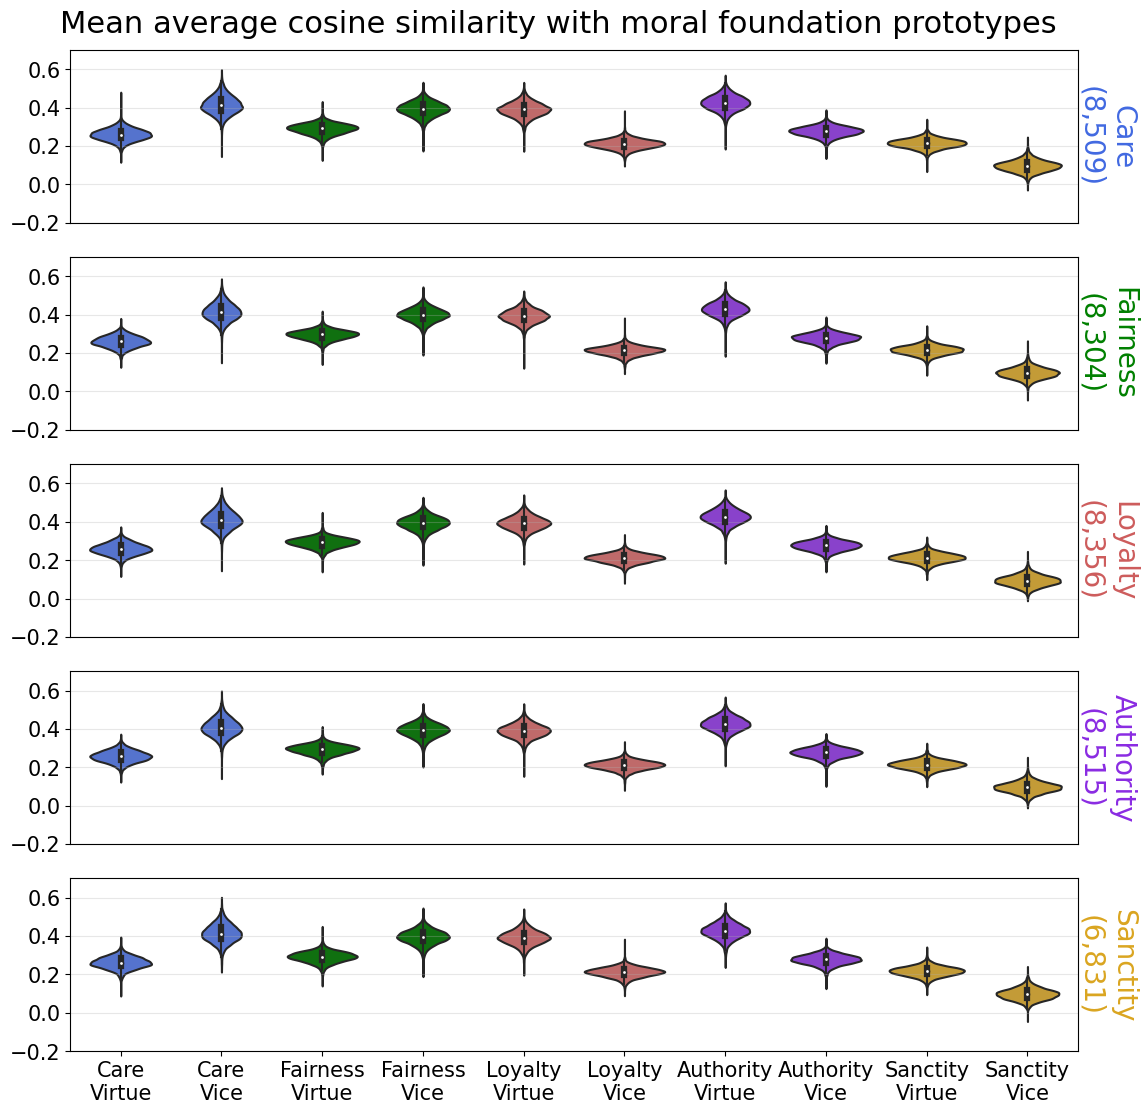

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(5, 1, figsize=(13, 13))
concept_list = ["care", "fairness", "loyalty", "authority", "sanctity"]
colors = ['royalblue', 'royalblue',
          'green', 'green',
          'indianred', 'indianred',
          'blueviolet', 'blueviolet', 
          'goldenrod', 'goldenrod']
mf_to_color = {"care": "royalblue",
               "fairness": "green",
               "loyalty": "indianred",
               "authority": "blueviolet",
               "sanctity": "goldenrod"}
for i, (concept, ax) in enumerate(zip(concept_list, axes)):
    scores_df = scores[corpus[concept + "_label"] == 1]
    
    sns.violinplot(data=scores_df, palette=colors, ax=ax)
    ax.grid(axis='y', alpha=0.3, zorder=0)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylim([-0.2, 0.7])
    ax.set_yticks(np.arange(-0.2, 0.71, 0.2))
    if i < len(axes) - 1:
        ax.set_xticks([])
    # Annotate
    x = 1.03 * np.max(ax.get_xlim())
    y = np.mean(ax.get_ylim())
    s = concept.capitalize() + "\n" + f"({scores_df.shape[0]:,})"
    ax.text(x=x, y=y, s=s, rotation=270, 
            ha="center", va="center", size=20, color=mf_to_color[concept])
plt.sca(axes[-1])
plt.xticks(range(10), [x.capitalize() + "\n" + y.capitalize() 
                       for x, y in map(lambda z: z.split("_"), scores_df.columns)],
           size=15)
fig.suptitle("Mean average cosine similarity with moral foundation prototypes", size=22, y=0.9,
             va="center", ha="center")

plt.show()